In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [9]:
resolution = 100
nfreq = 100

fcen = 1.75
df = 3.3

In [79]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000011
Iteration   1, error: 0.000008
Iteration   2, error: 0.000011
Iteration   3, error: 0.000047
Iteration   4, error: 0.000012
Iteration   5, error: 0.000012
Iteration   6, error: 0.000122
Iteration   7, error: 0.000021
Iteration   8, error: 0.000010
Iteration   9, error: 0.000008
Iteration  10, error: 0.000055
Iteration  11, error: 0.000011
Iteration  12, error: 0.000023
Iteration  13, error: 0.000111
Iteration  14, error: 0.000014
Iteration  15, error: 0.000026
Iteration  16, error: 0.000011
Iteration  17, error: 0.000015
Iteration  18, error: 0.000026
Iteration  19, error: 0.000010
Iteration  20, error: 0.000012
Iteration  21, error: 0.000018
Iteration  22, error: 0.000023
Iteration  23, error: 0.000009
Iteration  24, error: 0.000020
Iteration  25, error: 0.000007
Iteration  26, error: 0.000011
Iteration  27, error: 0.000011
Iteration  28, error: 0.000013
Iteration  29, error: 0.000012
Optimal error: 0.000007
Iteration   0, error: 64.226780
Iteration   1,

In [80]:
### ----- Refractive index ----- ###
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor

CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [81]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

In [82]:
Absorber_layer = 0.5

boundary_layers = [
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.Low),  # 좌측 Absorber
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.High), # 우측 Absorber
    mp.Absorber(thickness=Absorber_layer, direction=mp.Y, side=mp.High), # 상단 Absorber
    
]

In [83]:
Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [84]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=Cathode_center,
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=Alq3_center,
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=aNDP_center,
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=ITO_center,
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=Cover_center,
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=Glass_center,
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [85]:
cell_size = mp.Vector3(31, 2, 0)

In [86]:
source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [87]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


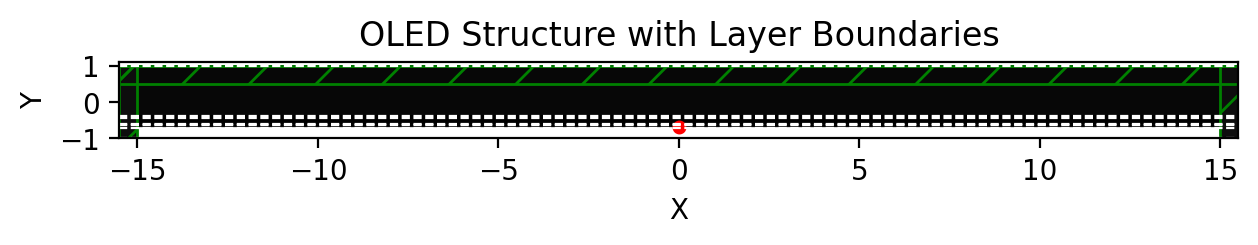

In [88]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    # output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    # eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    # ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

# near to far 각도 부여하는 방법에는 문제가 없다

가우시안에 대한 필드 분포 뽑기

In [22]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

# 박스 4면
x1 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

x2 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

y2 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

In [89]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power = sim.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/min/miniconda3/envs/mp/lib/python3.8/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


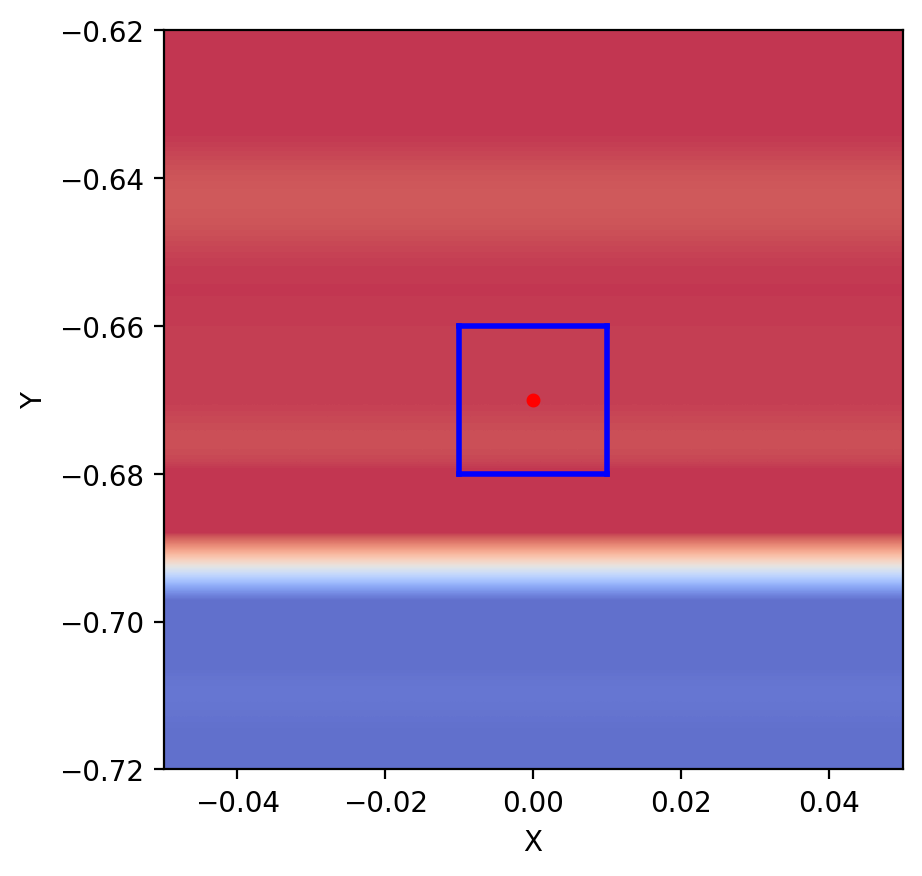

In [90]:
# center와 size를 사용해 Volume 객체 생성
vol = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 2, 0))
fig = plt.figure(dpi=200)
ax = plt.gca()

# 그 volume을 사용해서 2D 시각화
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,-0.67,0), size=mp.Vector3(0.1, 0.1, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)
plt.show()

In [56]:
#sim.run(until=50)
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ex, mp.Vector3(0,0,0), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 1.81198e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.6

In [78]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

# 저장 폴더 설정
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)


# 필드 시각화 함수
def save_frame(sim):
    eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
    field_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ex)

    plt.figure(figsize=(20, 5))
    plt.imshow(np.rot90(field_data), cmap='RdBu', extent=[-cell_size.x/2, cell_size.x/2, -cell_size.y/2, cell_size.y/2], interpolation='spline36',  vmin = -1, vmax = 1)
    plt.colorbar(label='Ex')
    plt.title(f"t = {sim.meep_time():.2f}")
    plt.xlabel("x (μm)")
    plt.ylabel("y (μm)")
    plt.tight_layout()
    
    frame_path = os.path.join(frame_dir, f"frame_{sim.meep_time():.2f}.png")
    plt.savefig(frame_path)
    plt.close()

# 시뮬레이션 실행 + 프레임 저장
sim.run(mp.at_every(1.0, save_frame),  # 1 time unit마다 저장
        until_after_sources=mp.stop_when_fields_decayed(100, mp.Ex, mp.Vector3(0,-0.67), 1e-3))

# 이미지들을 GIF로 변환
with imageio.get_writer("radiation.gif", mode="I", duration=0.2) as writer:
    for filename in sorted(os.listdir(frame_dir)):
        if filename.endswith(".png"):
            image = imageio.imread(os.path.join(frame_dir, filename))
            writer.append_data(image)

print("✅ radiation.gif 생성 완료!")


-----------
Initializing structure...
time for choose_chunkdivision = 2.00272e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.6

KeyboardInterrupt: 

In [ ]:
# net_power = np.array(mp.get_fluxes(x1))+np.array(mp.get_fluxes(x2))+np.array(mp.get_fluxes(y1))+np.array(mp.get_fluxes(y2))
net_power = np.square(net_power)

In [91]:
sim.run(until = 50)

-----------
Initializing structure...
time for choose_chunkdivision = 1.69277e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [104]:
net_power_fitting_al = mp.get_fluxes(box_power)

## Air에서의 far field E field 뽑는걸 이번주 목표로 -> Meep air far field

### Meep에서 air, sio2 

In [105]:
frequencies = mp.get_flux_freqs(x1)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
1.4286		6.490496e-03
1.4394		6.783806e-03
1.4502		7.101633e-03
1.4610		7.407199e-03
1.4719		7.736956e-03
1.4827		8.056556e-03
1.4935		8.398611e-03
1.5043		8.734267e-03
1.5152		9.089061e-03
1.5260		9.442660e-03
1.5368		9.810461e-03
1.5476		1.018344e-02
1.5584		1.056418e-02
1.5693		1.095730e-02
1.5801		1.135055e-02
1.5909		1.176388e-02
1.6017		1.216896e-02
1.6126		1.260197e-02
1.6234		1.301824e-02
1.6342		1.347013e-02
1.6450		1.389728e-02
1.6558		1.436732e-02
1.6667		1.480576e-02
1.6775		1.529357e-02
1.6883		1.574461e-02
1.6991		1.625041e-02
1.7100		1.671626e-02
1.7208		1.724086e-02
1.7316		1.772446e-02
1.7424		1.826910e-02
1.7532		1.877370e-02
1.7641		1.933969e-02
1.7749		1.986831e-02
1.7857		2.045659e-02
1.7965		2.101138e-02
1.8074		2.162198e-02
1.8182		2.220359e-02
1.8290		2.283518e-02
1.8398		2.344230e-02
1.8506		2.409188e-02
1.8615		2.472086e-02
1.8723		2.538345e-02
1.8831		2.602811e-02
1.8939		2.669681e-02
1.9048		2.734863e-02
1.9156		2.801459e-02
1.9264

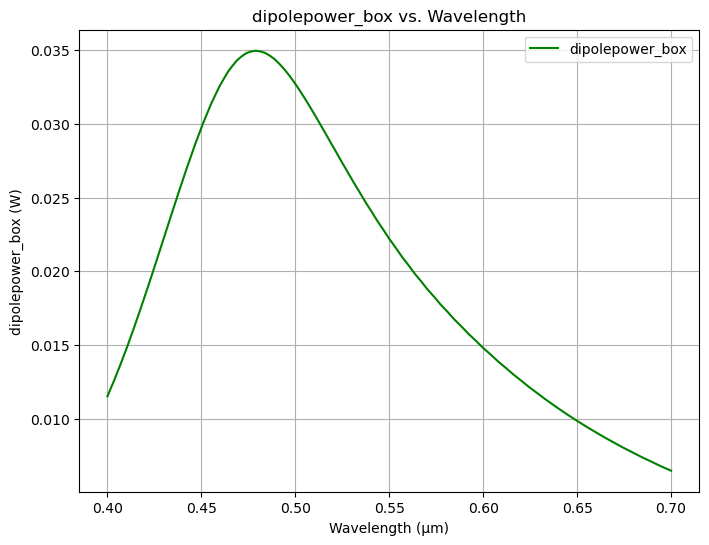

In [106]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power, '-', label='dipolepower_box', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('dipolepower_box (W)')
plt.title('dipolepower_box vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14
# plt.xlim([0.4, 0.7])
plt.legend()
plt.grid(True)
plt.show()

In [107]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [0.7        0.69473684 0.68955224 0.68444444 0.67941176 0.67445255
 0.66956522 0.6647482  0.66       0.65531915 0.65070423 0.64615385
 0.64166667 0.63724138 0.63287671 0.62857143 0.62432432 0.62013423
 0.616      0.61192053 0.60789474 0.60392157 0.6        0.59612903
 0.59230769 0.58853503 0.58481013 0.58113208 0.5775     0.57391304
 0.57037037 0.56687117 0.56341463 0.56       0.55662651 0.55329341
 0.55       0.54674556 0.54352941 0.54035088 0.5372093  0.53410405
 0.53103448 0.528      0.525      0.5220339  0.51910112 0.51620112
 0.51333333 0.51049724 0.50769231 0.50491803 0.50217391 0.49945946
 0.49677419 0.49411765 0.49148936 0.48888889 0.48631579 0.48376963
 0.48125    0.47875648 0.47628866 0.47384615 0.47142857 0.46903553
 0.46666667 0.46432161 0.462      0.45970149 0.45742574 0.45517241
 0.45294118 0.45073171 0.44854369 0.44637681 0.44423077 0.44210526
 0.44       0.43791469 0.43584906 0.43380282 0.4317757  0.42976744
 0.42777778 0.42580645 0.42385321 0.42191781

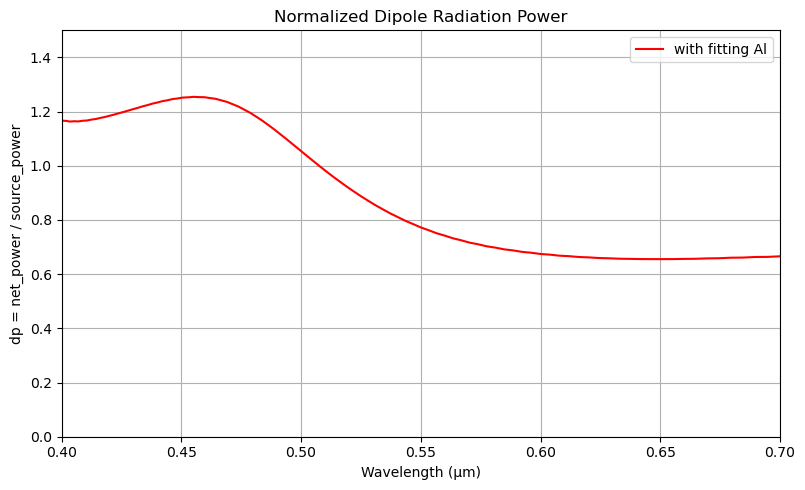

In [ ]:
dp_fitting_al = net_power_fitting_al / source_power
# dp_PEC = net_power_PEC / source_power

# 5. Plot
plt.figure(figsize=(8, 5))

plt.plot(wavelengths, dp_fitting_al,  label='with fitting Al', color='red')
# plt.plot(wavelengths, dp_PEC,  label='with PEC', color='blue')


plt.xlabel("Wavelength (μm)")
plt.ylabel("dp = net_power / source_power")
plt.title("Normalized Dipole Radiation Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.yscale("log")

plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()

sim.add_flux(...) → Fourier-transformed field 데이터를 누적 시작

sim.get_fluxes(flux_obj) → 누적된 데이터를 바탕으로 power 계산

sim.get_dft_array(...) → 실제 E, H field의 Fourier transformed 값을 배열로 받을 수 있음

→ 파장이 길어질수록 source dipole의 방사효율은 줄어들지만, 시스템은 에너지를 더 잘 전달함 → dp 증가.